# Module 05: Linear Regression with Nonlinear Effects

In [61]:
# packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

# set seed
seed = 4721

### We'll use the _Bikeshare_ data from ISLP for this activity. The metadata for _Bikeshare_ can be found [here](https://intro-stat-learning.github.io/ISLP/datasets/Bkeshare.html).

In [62]:
# Load the data
Bikeshare = load_data('Bikeshare')

In [63]:
# List the columns and their types
Bikeshare.dtypes

season           int64
mnth          category
day              int64
hr            category
holiday          int64
weekday          int64
workingday       int64
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
bikers           int64
dtype: object

### We will predict the `bikers` column, which is the total of casual and registered bikers. 
Then we can create a matrix of potential independent variables (X) and a dependent variable vector (y).

In [64]:
indep_vars = ['season', 'mnth', 'day', 'hr', 
              'holiday', 'weekday', 'workingday', 
              'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

X = Bikeshare[indep_vars]
y = Bikeshare['bikers']

### Before doing any other analyses, let's create training and test sets.

In [65]:
X_train, X_test, y_train, y_test, Train, Test = train_test_split(X, y, Bikeshare, 
                                                                 random_state = seed, 
                                                                 test_size = 0.25, 
                                                                 shuffle = True)
                             

### We can first summarize the variables in the training data.

In [66]:
Train.describe()

,season,day,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,bikers
count,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000
mean,2.515502,184.328243,0.028382,3.035169,0.679932,0.490066,0.469745,0.643862,0.191836,28.581212,114.752275,143.333488
std,1.102100,104.578153,0.166074,2.013836,0.466538,0.196942,0.175640,0.196966,0.124633,38.973040,109.394295,133.938856
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,95.000000,0.000000,1.000000,0.000000,0.320000,0.318200,0.490000,0.104500,3.000000,26.000000,31.000000
50%,3.000000,185.000000,0.000000,3.000000,1.000000,0.500000,0.484800,0.650000,0.194000,14.000000,89.000000,109.000000
75%,3.000000,274.000000,0.000000,5.000000,1.000000,0.660000,0.621200,0.810000,0.283600,38.000000,167.000000,211.000000
max,4.000000,365.000000,1.000000,6.000000,1.000000,0.960000,1.000000,1.000000,0.850700,272.000000,567.000000,651.000000


### Then we can create plots for each potential independent variable with `bikers` on training data.

In [ ]:
# Initialize the plots before drawing them
nrows = 4
ncols = 3
figsize = (5*nrows, 5*ncols)

fig, axes = subplots(nrows=nrows,
                     ncols=ncols,
                     figsize=figsize)

# Assign a grid location to each index
def range_to_grid(i, nrows, ncols):
    x=[]
    y=[]
    for n in range(nrows*ncols):
        x.append(n // ncols)
        y.append(n % ncols)
        # print(n,x[n],y[n]) # for testing this function
    return x[i],y[i]

# Plot the variables
for j in range(len(X_train.columns)):
    # print(range_to_grid(j,nrows,ncols)[0], range_to_grid(j,nrows,ncols)[1]) # testing
    axes[range_to_grid(j,nrows,ncols)[0],
         range_to_grid(j,nrows,ncols)[1]].plot(X_train.iloc[:,j], y_train, 'o')
    axes[range_to_grid(j,nrows,ncols)[0],
         range_to_grid(j,nrows,ncols)[1]].set_xlabel(X_train.columns[j])

### Since we see that the `hr` variable is periodic (with period 24), we will use trigonometric transforms as our spline basis functions

In [ ]:
# Data preprocessing
Train['hr_sin'] = round(np.sin(2*np.pi/24*Train['hr'].astype('int')),2)
Test['hr_sin'] = round(np.sin(2*np.pi/24*Test['hr'].astype('int')),2)
X_train['hr_sin'] = round(np.sin(2*np.pi/24*X_train['hr'].astype('int')),2)
X_test['hr_sin'] = round(np.sin(2*np.pi/24*X_test['hr'].astype('int')),2)

Train['hr_cos'] = round(np.cos(2*np.pi/24*Train['hr'].astype('int')),2)
Test['hr_cos'] = round(np.cos(2*np.pi/24*Test['hr'].astype('int')),2)
X_train['hr_cos'] = round(np.cos(2*np.pi/24*X_train['hr'].astype('int')),2)
X_test['hr_cos'] = round(np.cos(2*np.pi/24*X_test['hr'].astype('int')),2)

# spot-check this
Train.head()

,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers,hr_sin,hr_cos
708,1,Feb,32,21,0,2,1,cloudy/misty,0.22,0.2273,0.87,0.1343,0,64,64,-0.71,0.71
403,1,Jan,18,19,0,2,1,cloudy/misty,0.22,0.2273,0.80,0.1343,1,98,99,-0.97,0.26
3239,2,May,139,21,0,4,1,clear,0.54,0.5152,0.77,0.2836,29,180,209,-0.71,0.71
2231,2,April,97,20,0,4,1,clear,0.44,0.4394,0.62,0.1642,37,166,203,-0.87,0.50
2295,2,April,100,12,0,0,0,cloudy/misty,0.42,0.4242,0.88,0.1343,94,136,230,0.00,-1.00


## First Linear Regression Model with a spline

### We can create a column to represent the intercept in our model. 

Some packages do this automatically, but we will leverage the ISLP version, which does not.

In [ ]:
X_train['intercept'] = np.ones(X_train.shape[0])
X_test['intercept'] = np.ones(X_test.shape[0])

### We'll build a regression model to predict `bikers` that uses a straight line for `temp` and a spline with trig basis functions for `hr`.

In [ ]:
model_4 = sm.OLS(y_train, X_train[['intercept', 'temp', 'hr_sin', 'hr_cos']])
results_4 = model_4.fit()
summarize(results_4)

,coef,std err,t,P>|t|
intercept,28.0353,3.336,8.403,0.0
temp,235.2282,6.337,37.119,0.0
hr_sin,-69.3326,1.742,-39.791,0.0
hr_cos,-68.8858,1.737,-39.668,0.0


### We will evaluate this model *three ways*: Using R^2, using MSE, and then visually. 

For the last two, we will compare on _Train_ and on _Test_.

In [ ]:
# R^2 on training
results_4.rsquared

np.float64(0.4625500101774813)

In [ ]:
# Create helper functions for computing the mean squared error

def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def mse(y, y_hat):
    # calculate the residual error for each individual record
    resid = y - y_hat
    # square the residual (hence "squared error")
    sq_resid = resid**2
    # calculate the sum of squared errors
    SSR = sum(sq_resid)
    # divide by the number of records to get the mean squared error
    MSE = SSR / y.shape[0]
    return MSE

In [ ]:
predictions_train_4 = predict(X_train[['intercept', 'temp', 'hr_sin', 'hr_cos']], results_4)
print('MSE train: ', mse(y_train, predictions_train_4))

predictions_test_4 = predict(X_test[['intercept', 'temp', 'hr_sin', 'hr_cos']], results_4)
print('MSE test: ', mse(y_test, predictions_test_4))

MSE train:  9640.159887240901
MSE test:  9784.934237970212


### Here is a helpful tool for evaluating our model(s). 

Since the variables we're using aren't always being fit with straight lines, it's helpful to plot the average _actual_ y-value to the average _predicted_ y-value for each modeled feature.

**Note**: It is **not** recommended to leverage this tool on test data. This can quickly lead to unintentional overfitting on the test set, which could lead to a poor model on new data.

In [ ]:
def plot_avg_actual_vs_predicted_by_feature(X, y, y_pred, feature, target_name="Target"):
    df = pd.DataFrame({
        feature: X[feature],
        "actual": y,
        "predicted": y_pred
    })

    grouped = df.groupby(feature).mean().reset_index()

    plt.figure()
    plt.plot(grouped[feature], grouped["actual"], label="Average Actual")
    plt.plot(grouped[feature], grouped["predicted"], label="Average Predicted")
    plt.xlabel(feature)
    plt.ylabel(target_name)
    plt.legend()
    plt.show()

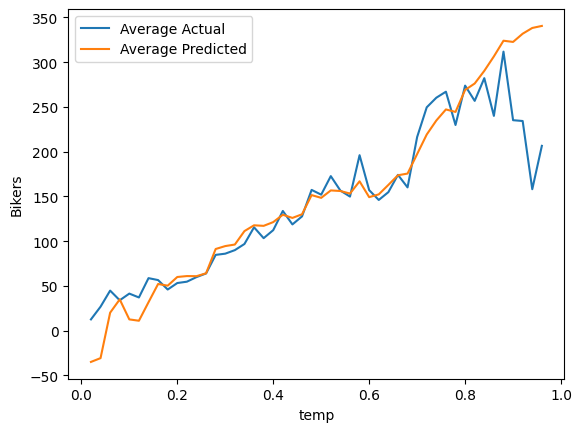

In [ ]:
plot_avg_actual_vs_predicted_by_feature(X=X_train, 
                                        y=y_train, 
                                        y_pred=predictions_train_4, 
                                        feature='temp', 
                                        target_name="Bikers"
                                        )

/tmp/ipykernel_3330/3267696864.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature).mean().reset_index()


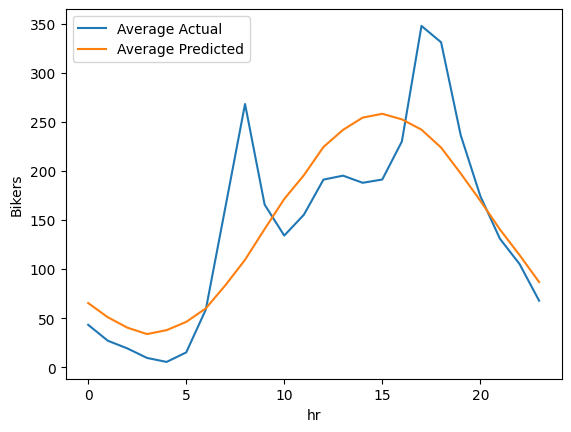

In [ ]:
plot_avg_actual_vs_predicted_by_feature(X=X_train, 
                                        y=y_train, 
                                        y_pred=predictions_train_4, 
                                        feature='hr', 
                                        target_name="Bikers"
                                        )

### We are seeing that there are spikes in bike rentals at rushhour times: 7am, 8am, 5pm, and 6pm. Let's incorporate a categorical variable to account for these. 

In [ ]:
# Data preprocessing
Train["rushhour"] = np.where(Train["hr"].astype('int').isin([7, 8, 17, 18]), 1, 0)
Test["rushhour"] = np.where(Test["hr"].astype('int').isin([7, 8, 17, 18]), 1, 0)
X_train["rushhour"] = np.where(X_train["hr"].astype('int').isin([7, 8, 17, 18]), 1, 0)
X_test["rushhour"] = np.where(X_test["hr"].astype('int').isin([7, 8, 17, 18]), 1, 0)

# spot-check this
Train[['hr', "rushhour"]].head(12)

,hr,rushhour
708,21,0
403,19,0
3239,21,0
2231,20,0
2295,12,0
5980,17,1
8002,2,0
6616,6,0
2320,14,0
5051,9,0


In [ ]:
model_5 = sm.OLS(y_train, X_train[['intercept','temp','hr_sin', 'hr_cos', 'rushhour']])
results_5 = model_5.fit()
summarize(results_5)

,coef,std err,t,P>|t|
intercept,4.0285,2.911,1.384,0.166
temp,238.3696,5.446,43.768,0.000
hr_sin,-69.2889,1.497,-46.275,0.000
hr_cos,-57.2105,1.512,-37.836,0.000
rushhour,137.8738,2.878,47.914,0.000


### Compute the R^2 coefficient for the new model.

In [ ]:
results_5.rsquared

np.float64(0.6031784560520795)

### Compute the MSE on the training and test sets for the new model. 

In [ ]:
predictions_train_5 = predict(X_train[['intercept', 'temp', 'hr_sin', 'hr_cos', 'rushhour']], results_5)
print('MSE train: ', mse(y_train, predictions_train_5))

predictions_test_5 = predict(X_test[['intercept', 'temp', 'hr_sin', 'hr_cos', 'rushhour']], results_5)
print('MSE test: ', mse(y_test, predictions_test_5))

MSE train:  7117.728538097113
MSE test:  7241.922982820616


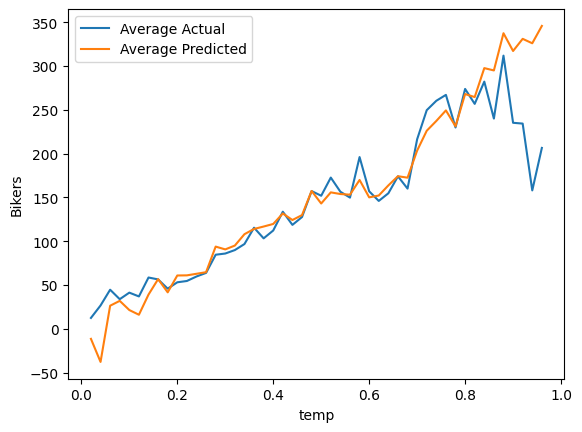

In [ ]:
plot_avg_actual_vs_predicted_by_feature(X=X_train, 
                                        y=y_train, 
                                        y_pred=predictions_train_5, 
                                        feature='temp', 
                                        target_name="Bikers"
                                        )

/tmp/ipykernel_3330/3267696864.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature).mean().reset_index()


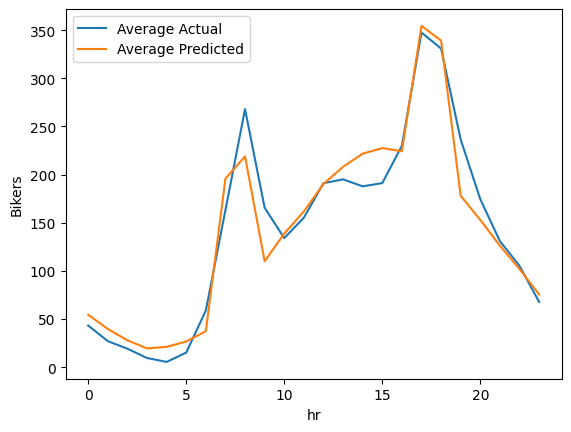

In [ ]:
plot_avg_actual_vs_predicted_by_feature(X=X_train, 
                                        y=y_train, 
                                        y_pred=predictions_train_5, 
                                        feature='hr', 
                                        target_name="Bikers"
                                        )

# Now, for your goal:

### Use the tools we've talked about in this module (categorical variables, interactions, splines, etc.) to build the best possible linear regression model. 

## **DO NOT** do any of the following, which would result in an invalid submission:
- Use techniques other than linear regression (specifically, you must use sm.OLS)
- Use postdictors (bikers, casual, registered) to predict bikers
- Change the random seed or anything with the train/test split
- Change any of the variables defined below this cell (model_final, results_final, predictions_train_final, predictions_test_final)
- Manually manipulate predictions

In [ ]:
# Data pre-processing (on Train, Test, X_train, and X_test)

Train['hr_sin2'] = np.sin(4*np.pi/24 * Train['hr'].astype(int))
Test['hr_sin2']  = np.sin(4*np.pi/24 * Test['hr'].astype(int))
X_train['hr_sin2'] = np.sin(4*np.pi/24 * X_train['hr'].astype(int))
X_test['hr_sin2']  = np.sin(4*np.pi/24 * X_test['hr'].astype(int))

Train['hr_cos2'] = np.cos(4*np.pi/24 * Train['hr'].astype(int))
Test['hr_cos2']  = np.cos(4*np.pi/24 * Test['hr'].astype(int))
X_train['hr_cos2'] = np.cos(4*np.pi/24 * X_train['hr'].astype(int))
X_test['hr_cos2']  = np.cos(4*np.pi/24 * X_test['hr'].astype(int))

Train['hr_sin3'] = np.sin(6*np.pi/24 * Train['hr'].astype(int))
Test['hr_sin3']  = np.sin(6*np.pi/24 * Test['hr'].astype(int))
X_train['hr_sin3'] = np.sin(6*np.pi/24 * X_train['hr'].astype(int))
X_test['hr_sin3']  = np.sin(6*np.pi/24 * X_test['hr'].astype(int))

Train['hr_cos3'] = np.cos(6*np.pi/24 * Train['hr'].astype(int))
Test['hr_cos3']  = np.cos(6*np.pi/24 * Test['hr'].astype(int))
X_train['hr_cos3'] = np.cos(6*np.pi/24 * X_train['hr'].astype(int))
X_test['hr_cos3']  = np.cos(6*np.pi/24 * X_test['hr'].astype(int))

X_train['temp2'] = X_train['temp']**2
X_test['temp2']  = X_test['temp']**2

Train['rushhour'] = np.where(Train['hr'].astype(int).isin([7, 8, 17, 18]), 1, 0)
Test['rushhour']  = np.where(Test['hr'].astype(int).isin([7, 8, 17, 18]), 1, 0)
X_train['rushhour'] = np.where(X_train['hr'].astype(int).isin([7, 8, 17, 18]), 1, 0)
X_test['rushhour']  = np.where(X_test['hr'].astype(int).isin([7, 8, 17, 18]), 1, 0)

X_train['rush_work'] = X_train['rushhour'] * X_train['workingday']
X_test['rush_work']  = X_test['rushhour']  * X_test['workingday']

X_train['temp_work'] = X_train['temp'] * X_train['workingday']
X_test['temp_work']  = X_test['temp']  * X_test['workingday']

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [ ]:
# Build your linear regression model here.
vars_to_include = [
    'intercept',
    'temp', 'temp2', 'atemp',
    'hr_sin', 'hr_cos',
    'hr_sin2', 'hr_cos2',
    'hr_sin3', 'hr_cos3',
    'rushhour',
    'rush_work',
    'hum',
    'windspeed'
] 

model_final = sm.OLS(y_train, X_train[vars_to_include])
results_final = model_final.fit()
summarize(results_final)

,coef,std err,t,P>|t|
intercept,42.2251,5.993,7.046,0.000
temp,314.9046,49.119,6.411,0.000
temp2,-166.5315,24.700,-6.742,0.000
atemp,97.1416,43.786,2.219,0.027
hr_sin,-64.3236,1.391,-46.248,0.000
hr_cos,-56.6613,1.398,-40.531,0.000
hr_sin2,-23.0031,1.308,-17.581,0.000
hr_cos2,-19.7003,1.567,-12.573,0.000
hr_sin3,12.0066,1.310,9.164,0.000
hr_cos3,5.9694,1.447,4.126,0.000


In [ ]:
predictions_train_final = predict(X_train[vars_to_include], results_final)
print('MSE train: ', mse(y_train, predictions_train_final))

predictions_test_final = predict(X_test[vars_to_include], results_final)
print('MSE test: ', mse(y_test, predictions_test_final))

MSE train:  5309.959748611401
MSE test:  5525.806754054608


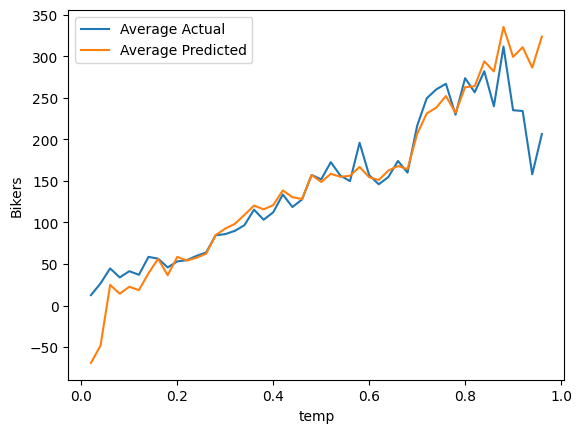

In [ ]:
plot_avg_actual_vs_predicted_by_feature(X=X_train, 
                                        y=y_train, 
                                        y_pred=predictions_train_final, 
                                        feature='temp', 
                                        target_name="Bikers"
                                        )